In [1]:
#
# Std lib imports
#
import os, sys, glob
import pandas as pd
import numpy as np
import tqdm as tqdm
import matplotlib.pyplot as plt

#
# Our lib imports
#
from lib.dataload import *
from lib.features import *
from lib.denoise import *

### Generating a Scores Matrix

In [2]:
# 
# Generate a dictionary of images with workers and scores
# to make into score matrix
#

# Specify files and relevant columns
csv_files = glob.glob('lib/batch-data/batch*')
column_headers = ['AssignmentStatus',
                  'Answer.set_number',
                  'WorkerId',
                  'Answer.slider_values',
                  'Answer.slider_values2']

dataDF = pd.DataFrame()

for f in csv_files:
    df = pd.read_csv(f)
    df = df[df.loc[:,'AssignmentStatus'] == 'Approved']
    df = df[df.loc[:,'Answer.set_number'] != 'initial']
    df = df.loc[:,column_headers]
    
    # Determine hit data file
    if re.match(r'.*batch[1-3]_',f) is not None:
        df['HitDataFile'] = np.repeat(0,len(df))
    elif re.match(r'.*batch[4-6]_',f) is not None:
        df['HitDataFile'] = np.repeat(1,len(df))
    else:
        df['HitDataFile'] = np.repeat(2,len(df))

    dataDF = pd.concat([dataDF,df], axis='index', ignore_index=True)

# Get all HIT Data files
hit_data_1_3 = np.genfromtxt('lib/batch-data/hit_data_1_3.csv',
                              delimiter=',',
                              dtype='str')[:,1:56]
hit_data_4_6 = np.genfromtxt('lib/batch-data/hit_data_4_6.csv',
                              delimiter=',',
                              dtype='str')[:,1:56]
hit_data_7 = np.genfromtxt('lib/batch-data/hit_data_7.csv',
                              delimiter=',',
                              dtype='str')[:,1:56]
# Get image names
im_names = pd.read_csv('../data/8k_image_names.csv',
                       header=None,
                       usecols=[0])
im_names = (im_names.loc[:,0]).tolist()
im_dict = {keys: None for keys in im_names}

for w in tqdm.tqdm(range(len(dataDF))):
    # Get worker stats
    worker_id = dataDF.loc[w,'WorkerId']
    set_num = int(dataDF.loc[w,'Answer.set_number'])
    slider1_vals = np.asarray(dataDF.loc[w,'Answer.slider_values'].split(','))[:-1].astype('int64')
    slider2_vals = np.asarray(dataDF.loc[w,'Answer.slider_values2'].split(','))[:-1].astype('int64')
    
    # Get set images by hit file
    if int(dataDF.loc[w,'HitDataFile']) == 0:
        set_names = hit_data_1_3[(set_num-1)%len(hit_data_1_3)]
    elif int(dataDF.loc[w,'HitDataFile']) == 1:
        set_names = hit_data_4_6[(set_num-1)%len(hit_data_4_6)]
    elif int(dataDF.loc[w,'HitDataFile']) == 2:
        set_names = hit_data_7[(set_num-1)%len(hit_data_7)]
    else:
        assert False, 'HIT Data File not assigned'
        
    # Populate im dict
    for n in range(len(set_names)):
        if im_dict[set_names[n]] is None:
            im_dict[set_names[n]] = np.asarray([worker_id,
                                                slider1_vals[n],
                                                slider2_vals[n]])
        else:
            im_dict[set_names[n]] = np.vstack((im_dict[set_names[n]],
                                               [worker_id,
                                                slider1_vals[n],
                                                slider2_vals[n]]))

for im in tqdm.tqdm(im_dict):
    if im_dict[im] is not None:
        if im_dict[im].ndim == 1:
            im_dict[im] = np.reshape(im_dict[im], (1,len(im_dict[im])))


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
100%|██████████| 8529/8529 [00:00<00:00, 2024975.59it/s]


In [5]:
#
# Create scores matrix
# im_dict is image dict with workers and scores
# dataDF is all data
# im_names is a list of all images
#

im_keys = np.asarray(list(im_dict.keys()))

workers = np.asarray(dataDF['WorkerId'])
scoresDF1 = pd.DataFrame(index=range(len(im_keys)), columns=np.unique(workers).tolist())
scoresDF2 = pd.DataFrame(index=range(len(im_keys)), columns=np.unique(workers).tolist())

idx = 0
for im in tqdm.tqdm(im_keys):
    if im_dict[im] is None:
        continue
    for worker_i in range(len(im_dict[im])):
        worker = im_dict[im][worker_i,0]
        slider1 = im_dict[im][worker_i,1]
        slider2 = im_dict[im][worker_i,2]
        
        # Set worker score for image in scoresDF
        scoresDF1.at[idx, worker] = slider1
        scoresDF2.at[idx, worker] = slider2
    idx+=1


scoresDF1 = scoresDF1.fillna(0)
scoresDF2 = scoresDF2.fillna(0)

100%|██████████| 8529/8529 [00:02<00:00, 3101.97it/s]


In [6]:
# 
# Generate matrices and save them
# scoresmat1 contain slider one scores
# scoresmat2 contain slider two scores
#
worker_list = list(scoresDF1.columns)
scoresmat1 = scoresDF1.to_numpy()
scoresmat2 = scoresDF2.to_numpy()

np.save('ImageRows', im_keys)
np.save('WorkerColumns', worker_list)
np.save('ScoresMat1',scoresmat1)
np.save('ScoresMat2',scoresmat2)

### Visualize the distribution of scores per image
Shows the distribiution of scores over ~100 images

100%|██████████| 85/85 [00:00<00:00, 46860.65it/s]


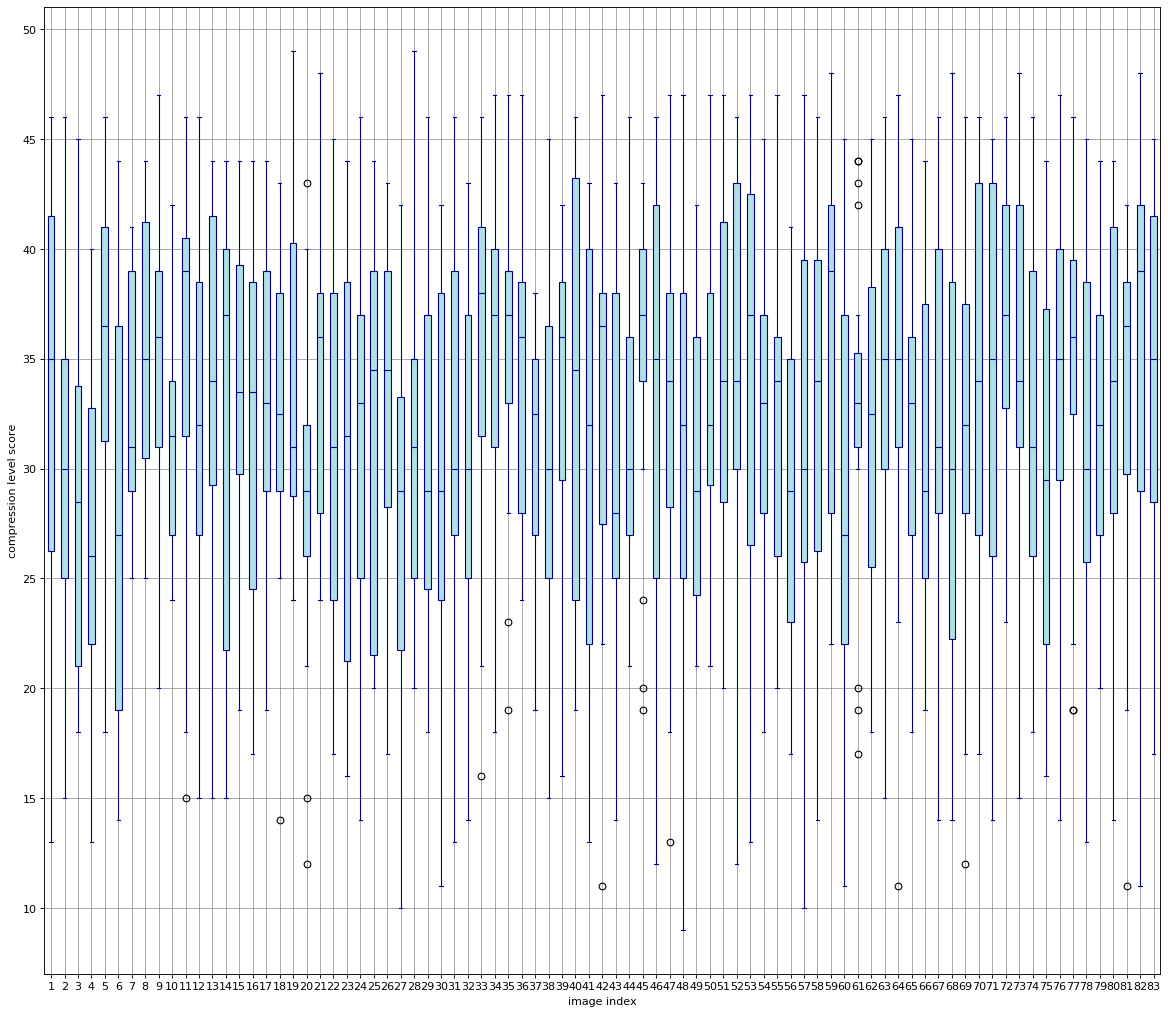

In [64]:
n = 100
data1 = []
im_vals = list(im_dict.values())
for i in tqdm.tqdm(range(len(im_dict)//n)):
    if im_vals[i] is None:
        continue
    data1.append(list(im_vals[i][:,1].astype('int64')))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bp = ax.boxplot(data1, notch=False, patch_artist=True)
ax.set_xlabel('image index')
ax.set_ylabel('compression level score')

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='navy')

for patch in bp['boxes']:
    patch.set(facecolor='powderblue') 

plt.grid(color='dimgrey', linestyle='-', linewidth=0.5)

plt.savefig('Scores100Images.png')
plt.show()

### Plot correlation between workers

In [68]:
#
# Take the average of samples srcc scores between two
# groups of workers randomly split
#
epochs = 100

import numpy.random as npr
import scipy.stats

srcc1 = 0.0
srcc2 = 0.0

for i in tqdm.tqdm(range(epochs)):
    w_dict = {}
    npr.shuffle(workers)
    g1 = workers[:len(workers)//2]
    g2 = workers[len(workers)//2:]
    
    for im in im_dict:
        g1_num = 0
        g2_num = 0
        g1_avg_s1 = 0
        g1_avg_s2 = 0
        g2_avg_s1 = 0
        g2_avg_s2 = 0
        
        if im_dict[im] is None:
            continue
        for j in range(len(im_dict[im][:,0])):
            worker = im_dict[im][j,0]
            if (worker in g1):
                g1_num+=1
                g1_avg_s1+=int(im_dict[im][j,1])
                g1_avg_s2+=int(im_dict[im][j,2])
            else:
                g2_num+=1
                g2_avg_s1+=int(im_dict[im][j,1])
                g2_avg_s2+=int(im_dict[im][j,2])
        if ((g1_num>=10) and (g2_num>=10)):
           w_dict[im] = [g1_avg_s1/g1_num, 
                         g2_avg_s1/g2_num, 
                         g1_avg_s2/g1_num, 
                         g2_avg_s2/g2_num]


    g1s1 =[] 
    g2s1 =[] 
    g1s2 =[] 
    g2s2 =[] 
    
    for j in w_dict:
        g1s1.append(w_dict[j][0])
        g2s1.append(w_dict[j][1])
        g1s2.append(w_dict[j][2])
        g2s2.append(w_dict[j][3])
    

    srcc1+=scipy.stats.spearmanr(np.array(g1s1),np.array(g2s1))[0]
    srcc2+=scipy.stats.spearmanr(np.array(g1s2),np.array(g2s2))[0]

srcc1 = srcc1/float(epochs)
srcc2 = srcc2/float(epochs)

print('Average SRCC for slider 1:',srcc1)
print('Average SRCC for slider 2:',srcc2)

100%|██████████| 100/100 [18:37<00:00, 11.17s/it]

Average SRCC for slider 1: -0.002635940834586427
Average SRCC for slider 2: 0.0003984003001191822


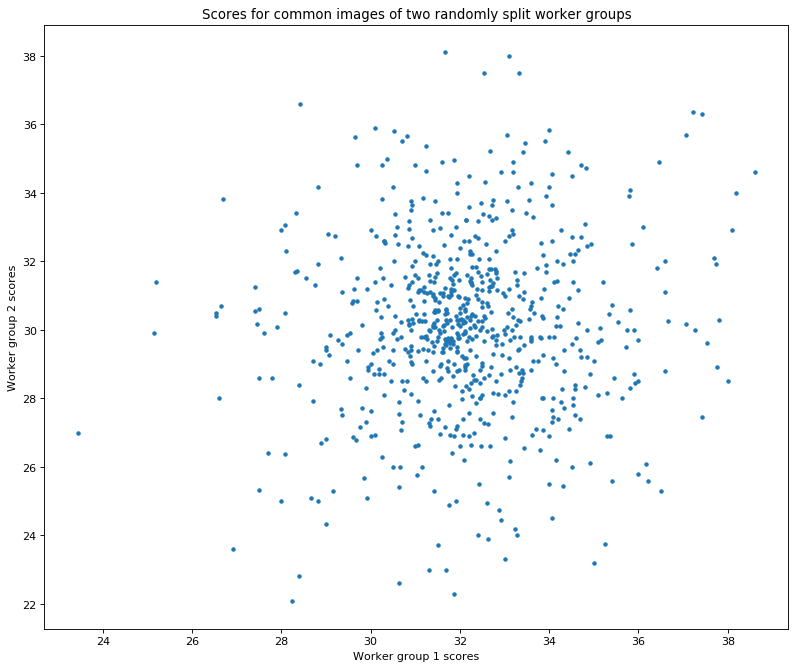

In [77]:
#
# Plot one iteration of correlations
#
x1 =[] 
y1 =[] 
x2 =[] 
y2 =[] 

for i in w_dict:
    x1.append(w_dict[i][0])
    y1.append(w_dict[i][1])
    x2.append(w_dict[i][2])
    y2.append(w_dict[i][3])

mpl.rcParams['lines.markersize'] = 3
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(x1, y1) 
ax.set_title('Scores for common images of two randomly split worker groups')
ax.set_xlabel('Worker group 1 scores')
ax.set_ylabel('Worker group 2 scores')
plt.savefig('SRCC_Corr.png')
plt.show()

### Correlating mean scores with image features
Took different aspects of the image such as luminence, contrast, fft and explored correlations (if any) between those features and image scores

In [109]:
#
# Make the data into a list of mean scores and image names
# using our lib methods
# 
image_list, scores_s1, scores_s2 = format_data(dataDF)


In [124]:
def get_image(image_name):
    base = '../data/8k_data/'
    image = cv2.imread(base + image_name)
    return image

In [129]:
rms_contrast = []
luminance = []
fft = []

for im_name in tqdm.tqdm(image_list):
    rms_contrast.append(RMS_Contrast(get_image(im_name)))
    luminance.append(AVG_Luminance(get_image(im_name)))
    fft.append(image_fft(get_image(im_name)))
    

100%|██████████| 8474/8474 [21:34<00:00,  6.55it/s]


In [137]:
fft[0].shape

(375, 500)

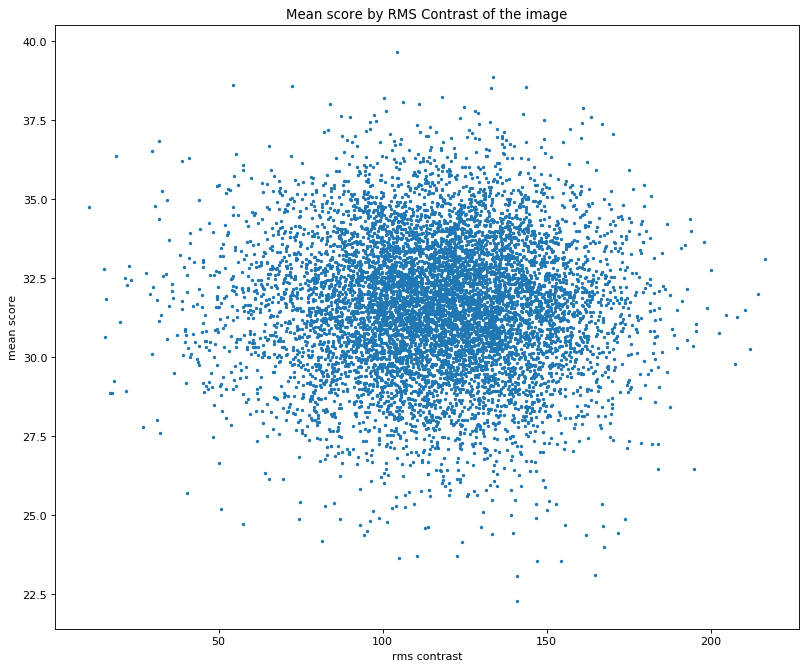

In [139]:
#
# Plot Contrast
#
mpl.rcParams['lines.markersize'] = 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(rms_contrast, scores_s1) 
ax.set_title('Mean score by RMS Contrast of the image')
ax.set_xlabel('rms contrast')
ax.set_ylabel('mean score')
plt.savefig('Contrast.png')
plt.show()

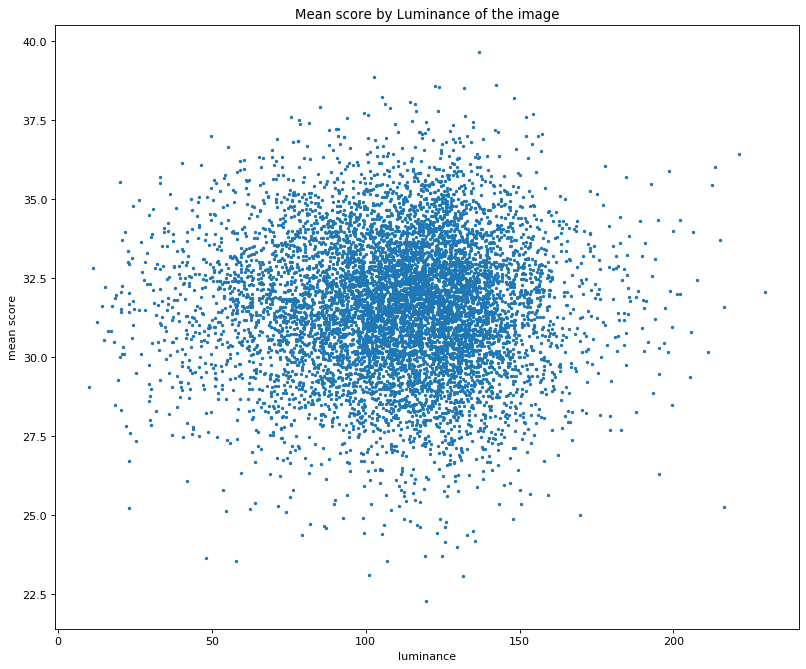

In [140]:
#
# Plot Luminance
#
mpl.rcParams['lines.markersize'] = 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(luminance, scores_s1) 
ax.set_title('Mean score by Luminance of the image')
ax.set_xlabel('luminance')
ax.set_ylabel('mean score')
plt.savefig('Luminance.png')
plt.show()

### Note: srcc denoising but we need to implement mpl first - takes a very long time

In [ ]:
#
# Denoise the data by SRCC of workers to other workers
#
#
import scipy.stats
#def srcc_outlier_denoising(im_dict, data, percentile):
    # Take each worker and map out their 55 image scores with all the
    # other responses for those 55 images
    # Then hold out their scores and calculate the srcc for all 55 images
    # Give worker a pentalty score of 1 - spearmanr
    # Rank workers in terms of these penalty scores and choose elimination threshold
    # Eliminate worker responses that are above this elimination penalty score    
    
image_idx = np.load('ImageRows.npy', allow_pickle=True)
worker_cols = np.load('WorkerColumns.npy', allow_pickle=True)
scoresmat1 = np.load('ScoresMat1.npy', allow_pickle=True)
scoresmat2 = np.load('ScoresMat2.npy', allow_pickle=True)
    

worker_penalties = dict(zip(worker_cols,np.zeros(len(worker_cols))))
for worker_i in tqdm.tqdm(range(len(worker_cols))):
    worker_scores = []
    all_scores = []
    for image_i in range(len(image_idx)):
        if scoresmat1[image_i,worker_i] != 0:
            worker_scores.append(scoresmat1[image_i,worker_i].astype('int64'))
            all_scores.append(np.mean(scoresmat1[np.nonzero(scoresmat1)].astype('int64')))
    worker_penalties[worker_cols[worker_i]] = 1 - scipy.stats.spearmanr(worker_scores, all_scores)[0]


In [ ]:
#
# Pick threshold for eliminating workers
#
percentile=90
penalties = np.fromiter(worker_penalties.values(), dtype=float)
threshold = np.percentile(penalties,percentile)
    
worker_idx = dict(zip(worker_cols,range(len(worker_cols))))
# Remove bad workers
for worker in worker_penalties.keys():
    if worker_penalties[worker] > threshold:
        dn_scoresmat1 = np.delete(scoresmat1, worker_idx[worker], axis=1)
        dn_scoresmat2 = np.delete(scoresmat2, worker_idx[worker], axis=1)
        dn_worker_cols = np.delete(worker_cols, worker_idx[worker])

# Remove from all the data
#for all_workers in data['WorkerId']:
#    if workers2.get(all_workers, None) == None:
#            idx = data.index[data['WorkerId'] == all_workers].tolist()
#            data = data.drop(idx, axis='index')
#            data = data.reset_index(drop=True)